# Galaxy explorer: images and EAZY results

* Load and print results
* Galaxy card compiling color image and plots

## Imports

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import join
from os.path import expanduser
home = expanduser("~")

import astropy  # version 4.2 is required to write magnitudes to ecsv file
import astropy.io.fits as pyfits
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, AsinhStretch, SqrtStretch, LogStretch, LinearStretch, hist, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats

from importlib import reload

In [2]:
import eazy
import eazy.hdf5

In [3]:
from astropy.table import Table
import astropy.units as u
import astropy

# for labeling color image
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.wcs as wcs

In [4]:
# to show segmentation map
import photutils

In [5]:
import numpy as np
from glob import glob
import string
from importlib import reload

import os
from os.path import expanduser
home = expanduser("~")

In [6]:
# color images
import PIL
from PIL import Image, ImageDraw, ImageFont
PIL.Image.MAX_IMAGE_PIXELS = 933120000  # allow to load large images avoiding DecompressionBombError

In [7]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
#%matplotlib notebook
#plt.style.use(os.path.join(home, 'p', 'matplotlibrc.txt')) # https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MultipleLocator
from mpl_toolkits.axes_grid1 import ImageGrid

## Helper functions

In [8]:
#import coeSEDplot

In [9]:
def find_object_in_catalog(RA, Dec):
    object_coordinates = SkyCoord(ra=RA*u.deg, dec=Dec*u.deg)
    
    # First look in segmentation map:
    x, y = image_wcs.world_to_pixel(object_coordinates)
    x = roundint(x)
    y = roundint(y)
    id = segm.data[y,x]
    
    # If nothing there, check for nearby object
    if not id:
        catalog_coordinates = SkyCoord(ra=eazy_results['ra'], dec=eazy_results['dec'])  # *u.deg
        idx, d2d, d3d = object_coordinates.match_to_catalog_sky(catalog_coordinates)
        id = eazy_results['id'][idx]
    
    return id

In [10]:
def roundint(x):
    return np.round(x).astype(int)
    
def extract_id(cat, id, idlabel='id'): # choose_object select_object
    duck_duck_goose = cat[idlabel] == int(id)
    if len(duck_duck_goose):
        obj = cat[duck_duck_goose]
    return obj[0]

In [11]:
def roundint(x):
    return int(np.round(x))

def slices_extent(x, y, dx, dy=0):
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

# START HERE

In [12]:
image_files_list = glob('../images/20mas/*_sci.fits*')
image_files_list = list(np.sort(image_files_list))
image_files_list

['../images/20mas/macs0647-grizli-v4.0-f115w-clear_drc_sci.fits',
 '../images/20mas/macs0647-grizli-v4.0-f150w-clear_drc_sci.fits',
 '../images/20mas/macs0647-grizli-v4.0-f200w-clear_drc_sci.fits',
 '../images/20mas/macs0647-grizli-v4.0-f277w-clear_20mas_sci.fits',
 '../images/20mas/macs0647-grizli-v4.0-f356w-clear_20mas_sci.fits',
 '../images/20mas/macs0647-grizli-v4.0-f444w-clear_20mas_sci.fits']

In [13]:
def extract_filter(image_file):
    return os.path.basename(image_file).split('-')[3].lower()#.split('-')[1]
    #return os.path.basename(image_file).split('_')[-2].lower().split('-')[1]
    #return image_file.split('_')[0].lower().split('-')[1]

In [14]:
filters = list(map(extract_filter, image_files_list))

# Remove stacked image _total_sci.fits.gz if present
exclude_total = [filt != 'total' for filt in filters]
image_files_list = list(np.array(image_files_list)[exclude_total])
filters = list(np.array(filters)[exclude_total])

image_files_dict = {}
for i, filt in enumerate(filters):
    image_files_dict[filt] = image_files_list[i]
    print(filt, image_files_dict[filt])

f115w ../images/20mas/macs0647-grizli-v4.0-f115w-clear_drc_sci.fits
f150w ../images/20mas/macs0647-grizli-v4.0-f150w-clear_drc_sci.fits
f200w ../images/20mas/macs0647-grizli-v4.0-f200w-clear_drc_sci.fits
f277w ../images/20mas/macs0647-grizli-v4.0-f277w-clear_20mas_sci.fits
f356w ../images/20mas/macs0647-grizli-v4.0-f356w-clear_20mas_sci.fits
f444w ../images/20mas/macs0647-grizli-v4.0-f444w-clear_20mas_sci.fits


In [15]:
field = os.path.basename(image_files_list[0]).split('-')[0]
#field = 'macs0647'
field

'macs0647'

In [16]:
#idata = 'sci'  # index where science data is
idata = 0  # index where science data is

In [17]:
# Color image
#field = 'whl0137'
color_image_file = '../color/%s_color.png' % field
color_image_file = '../color/%s_color_sw_bright.png' % field
im = Image.open(color_image_file)
color_image = np.asarray(im)
color_image = color_image[::-1]  # flip top-bottom
color_image_file, color_image.shape

('../color/macs0647_color_sw_bright.png', (24576, 16384, 3))

# Combined output file: photometry + photo-z's

In [18]:
outfile = field + '_phot-eazy.ecsv'
indir = '../catalogs'
outfile = os.path.join(indir, outfile)
if os.path.exists(outfile):
    print('Loading', outfile)
    catalog = astropy.io.ascii.read(outfile)

Loading ../catalogs/macs0647_phot-eazy.ecsv


In [19]:
catalog[:2]

id,ra,dec,x,y,z_spec,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f115w_flux,f115w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f150w_flux,f150w_fluxerr,f160w_flux,f160w_fluxerr,f200w_flux,f200w_fluxerr,f275wu_flux,f275wu_fluxerr,f277w_flux,f277w_fluxerr,f336wu_flux,f336wu_fluxerr,f356w_flux,f356w_fluxerr,f390wu_flux,f390wu_fluxerr,f435w_flux,f435w_fluxerr,f444w_flux,f444w_fluxerr,f475w_flux,f475w_fluxerr,f555w_flux,f555w_fluxerr,f606w_flux,f606w_fluxerr,f625w_flux,f625w_fluxerr,f775w_flux,f775w_fluxerr,f814w_flux,f814w_fluxerr,f850lp_flux,f850lp_fluxerr,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,mass,sfr,Lv,LIR,energy_abs,Lu,Lj,L1400,L2800,LHa,LOIII,LHb,LOII,MLv,Av,lwAgeV,mass_p,sfr_p,Lv_p,LIR_p,energy_abs_p,Lu_p,Lj_p,L1400_p,L2800_p,LHa_p,LOIII_p,LHb_p,LOII_p,Av_p,ssfr_p,rest120,rest120_err,rest121,rest121_err,rest156,rest156_err,rest157,rest157_err,rest158,rest158_err,rest159,rest159_err,rest160,rest160_err,rest414,rest414_err,rest415,rest415_err,rest416,rest416_err
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solMass,solMass / yr,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solLum,solMass / solLum,,Gyr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1,102.015220,70.161446,4098.274752800464,1.999824071826548,-1.0,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,0,-1.0,-1.0,-1.0,27082581599519.1,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0e+00,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000
2,101.948789,70.161459,8156.305414383205,1.9979236794378306,-1.0,-99.000,-99.000,-99.000,-99.

In [20]:
JD_ids = {'JD1':3593, 'JD2':3349, 'JD3':4871, 'JD1c':3621, 'JD2c':3314, 'JD3c':4858}

In [21]:
id = JD_ids['JD1']

# Show stamps

In [22]:
dx = dy = 25  # half stamp size
2 * dx * .02 * u.arcsec

<Quantity 1. arcsec>

In [23]:
obj = extract_id(catalog, id)
x = obj['x']
y = obj['y']
#xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
slices, extent = slices_extent(x, y, dx, dy)

In [24]:
pixel_size = 0.02 * u.arcsec
pixel_area = pixel_size ** 2
(u.MJy / u.sr).to(u.nJy / pixel_area)

9.401772215639154

In [25]:
label = 'JD1c'
id = JD_ids[label]
obj = extract_id(catalog, id)
x = obj['x']
y = obj['y']
#xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
slices, extent = slices_extent(x, y, dx, dy)

In [26]:
#filt = 'f277w'
filt = 'f150w'
data = fits.open(image_files_dict[filt])[idata].data
stamp = data[slices]
stamp *= 0.9536
stamp *= (u.MJy / u.sr).to(u.nJy / pixel_area)
stamp = np.where(stamp, stamp, np.nan) # Set data=nan where data=0
norm = simple_norm(stamp, 'asinh', min_percent=1, max_percent=100)
norm

In [27]:
norm.vmin, norm.vmax

(-0.28955575823783875, 1.6059861183166504)

In [28]:
np.max(stamp)

1.6059861

In [29]:
np.max(stamp) * 0.9536

1.5314683624267578

In [30]:
#norm = ImageNormalize(vmin=-0.3, vmax=4.35, stretch=AsinhStretch())

In [31]:
flux_corrections_A35 = 0.9687, 0.9536, 0.9658, 1.0239, 0.9763, 1.0073
flux_corrections_A15 = 0.9826, 0.9777, 0.9891, 1.0239, 0.9763, 1.0073

/var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_296/3120345808.py:46: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible


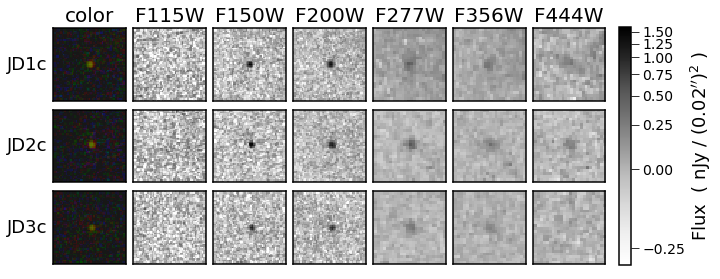

In [46]:
# https://matplotlib.org/stable/tutorials/intermediate/constrainedlayout_guide.html

ny, nx = 3, 7
#fig, ax = plt.subplots(ny, nx, figsize=(9.5, 4), layout="constrained")
fig, ax = plt.subplots(ny, nx, figsize=(10, 4), layout="constrained")

for iy in range(ny):
    label = 'JD%dc' % (iy+1)
    id = JD_ids[label]
    obj = extract_id(catalog, id)
    x = obj['x']
    y = obj['y']
    #xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
    slices, extent = slices_extent(x, y, dx, dy)

    if iy < 2:
        flux_corrections = flux_corrections_A35  # JD1,2
    else:
        flux_corrections = flux_corrections_A15  # JD3
    
    for ix in range(nx):
        if ix == 0:
            im = ax[iy,ix].imshow(color_image[slices], origin='lower', interpolation='none')            
            ax[iy,ix].set_ylabel(label, rotation=0, labelpad=18, va='center')
            if iy == 0:
                ax[iy,ix].set_title('color')
        else:
            filt = filters[ix-1]
            flux_correction = flux_corrections[ix-1]
            i = ix + (iy-2) * nx
            data = fits.open(image_files_dict[filt])[idata].data
            stamp = data[slices]
            stamp *= flux_correction
            if ix > 3:
                stamp /= 4
            stamp *= (u.MJy / u.sr).to(u.nJy / pixel_area)
            #print(stamp.max())
            im = ax[iy,ix].imshow(stamp, extent=extent, cmap='Greys', norm=norm, origin='lower', interpolation='None')
            if iy == 0:
                ax[iy,ix].set_title(filt.upper())
                
        ax[iy,ix].set_xticks([])
        ax[iy,ix].set_yticks([])


plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.subplots_adjust(wspace=0.1, hspace=0.1, right=1)
#plt.subplots_adjust(wspace=0.1, hspace=0.1, right=1.05)

# Colorbar
cbar = fig.colorbar(im, ax=ax, shrink=1, pad=0.02)
#cbar.set_label('Flux (nJy / (0.02$\\arcsec$)$^2$)')
cbar.set_label('Flux  ( nJy / (0.02$^{\\prime\\prime}$)$^2$ )')
#cbar.set_label('Flux [nJy / (0.02$^{\\prime\\prime}$ pixel)]')

plt.savefig('MACS0647-JDc_stamps.png', dpi=800)
plt.savefig('MACS0647-JDc_stamps.pdf', dpi=800)  # image resolution isn't great; not sure why...
# png has better resolution; can convert to PDF using:
# Preview - Print - Paper size - Manage custom sizes - 10.5" x 4" w/ 0" margins; makes a 2MB file
#plt.show()